In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os
from bs4 import BeautifulSoup
import time
import requests
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import random
import scipy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import pickle
from joblib import dump, load

import warnings

# Set certain settings for the notebook
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Check current directory
os.getcwd()

'C:\\Users\\imacd_0odruq3\\Documents\\sports_gambling\\sports_gambling_algorithm'

In [3]:
# Read in data files

betting_lines = pd.read_csv('../data/betting_data_final')
game_spreads = pd.read_csv('../data/games_with_spread_preds.csv')

In [4]:
# Function to get returns from over/under bets 

def calculate_return_using_ml(line, wager, is_win, return_includes_wager=False):
    if return_includes_wager:
        add_on = wager
    else:
        add_on = 0
    if is_win == 'Win':
        if line > 0:
            return np.round(((line/100)*wager + add_on), 2)
        else:
            return np.round(((100/abs(line))*wager + add_on), 2)
    elif is_win == 'Push':
        return add_on
    else:
        return np.round(-wager, 2)

def get_return_over_under_100(game, bet_over=True):
    if bet_over:
        if game['Open Over/Under Result'] == 'Over': 
            result = 'Win'
        elif game['Open Over/Under Result'] == 'Under':
            result = 'Loss'
        else:
            result = 'Push'
            
    if not bet_over:
        if game['Open Over/Under Result'] == 'Over': 
            result = 'Loss'
        elif game['Open Over/Under Result'] == 'Under':
            result = 'Win'
        else:
            result = 'Push'
    
    
    return calculate_return_using_ml(game['Total Score Over ML Open'], 100, is_win=result)

In [5]:
gambling_df = betting_lines.merge(game_spreads, left_on=['season', 'week', 'Home Team', 'Away Team'],
                                 right_on=['season', 'week', 'home_x', 'away_x'])
gambling_df['over_bet_return'] = gambling_df.apply(lambda x: get_return_over_under_100(x, bet_over=True), axis=1)
gambling_df['under_bet_return'] = gambling_df.apply(lambda x: get_return_over_under_100(x, bet_over=False), axis=1)

gambling_df['home_line_diff_algo'] = gambling_df.apply(lambda x: x['Home Line Open'] - x.home_spread_algo, axis=1)
gambling_df['away_line_diff_algo'] = gambling_df.apply(lambda x: x['Away Line Open'] - x.away_spread_algo, axis=1)
gambling_df['home_line_diff_elo'] = gambling_df.apply(lambda x: x['Home Line Open'] - x.home_spread_elo, axis=1)
gambling_df['away_line_diff_elo'] = gambling_df.apply(lambda x: x['Away Line Open'] - x.away_spread_elo, axis=1)
gambling_df['total_score_diff_algo'] = gambling_df.apply(lambda x: x.total_score_pred - x['Total Score Open'], axis=1)
gambling_df

,Unnamed: 0_x,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close,Home Odds ML Open,Home Odds ML Close,Away Odds ML Open,Away Odds ML Close,Home Line Odds ML Open,Home Line Odds ML Close,Away Line Odds ML Open,Away Line Odds ML Close,Total Score Over ML Open,Total Score Over ML Close,Total Score Under ML Open,Total Score Under ML Close,Total Score,Open Over/Under Result,Closing Over/Under Result,Home Score Actual Line,Away Score Actual Line,Opening Winner,Closing Winner,Opening Winner Specific,Closing Winner Specific,Winner HA,Line Open Cover,Line Close Cover,Line Open Cover HA,Line Close Cover HA,Home ML Bet Return,Away ML Bet Return,Home Spread Bet Return,Away Spread Bet Return,Favorite ML Bet Return,Underdog ML Bet Return,Favorite Spread Bet Return,Underdog Spread Bet Return,implied_prob_home_open,implied_prob_away_open,implied_prob_home_close,implied_prob_away_close,total_implied_prob_open,total_implied_prob_close,week,season,Unnamed: 0_y,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_score_pred,away_score_pred,total_score_pred,home_spread_algo,away_spread_algo,home_spread_elo,away_spread_elo,over_bet_return,under_bet_return,home_line_diff_algo,away_line_diff_algo,home_line_diff_elo,away_line_diff_elo,total_score_diff_algo
0,0,2022-01-17,Los Angeles Rams,Arizona Cardinals,34,11,False,True,False,-4.5,-3.5,4.5,3.5,50.5,49.0,-200.0,-172.0,170.0,150.0,-111.0,100.0,-111.0,-120.0,-111.0,-111.0,-111.0,-111.0,45,Under,Under,-23,23,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,50.00,-100.00,90.09,-100.00,50.00,-100.0,90.09,-100.00,0.666667,0.370370,0.632353,0.400000,1.037037,1.032353,19,2021,0,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,25.336177,22.903473,48.668136,-2.432703,2.432703,-3.300755,3.300755,-100.00,90.09,-2.067297,2.067297,-1.199245,1.199245,-1.831864
1,1,2022-01-16,Kansas City Chiefs,Pittsburgh Steelers,42,21,False,True,False,-13.5,-12.5,13.5,12.5,46.5,47.0,-714.0,-833.0,500.0,550.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,63,Over,Over,-21,21,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,14.01,-100.00,90.09,-100.00,14.01,-100.0,90.09,-100.00,0.877150,0.166667,0.892819,0.153846,1.043817,1.046665,19,2021,1,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,29.034506,20.149831,49.473663,-8.884675,8.884675,-6.687744,6.687744,90.09,-100.00,-4.615325,4.615325,-6.812256,6.812256,2.973663
2,2,2022-01-16,Dallas Cowboys,San Francisco 49ers,17,23,False,True,False,-3.0,-3.5,3.0,3.5,50.5,51.0,-161.0,-185.0,140.0,165.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,40,Under,Under,6,-6,Underdog,Underdog,Away Underdog,Away Underdog,Away,Underdog,Underdog,Away,Away,-100.00,140.00,-100.00,90.09,-100.00,140.0,-100.00,90.09,0.616858,0.416667,0.649123,0.377358,1.033525,1.026481,19,2021,2,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,29.204910,20.528647,49.783347,-8.676262,8.676262,-1.883657,1.883657,-100.00,90.09,5.676262,-5.676262,-1.116343,1.116343,-0.716653
3,3,2022-01-16,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,False,True,False,-8.5,-7.0,8.5,7.0,49.0,47.0,-400.0,-370.0,320.0,280.0,-111.0,-116.0,-111.0,-105.0,-111.0,-111.0,-111.0,-111.0,46,Under,Under,-16,16,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,25.00,-100.00,90.09,-100.00,25.00,-100.0,90.09,-100.00,0.800000,0.238095,0.787234,0.263158,1.038095,1.050392,19,2021,3,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,46,Home,1,24.252277,21.560780,46.149105,-2.691497,2.691497,-5.634525,5.634525,-100.00,90.09,-5.808503,5.808503,-2.865475,2.865475,-2.850895
4,4,2022-01-15,Buffalo Bills,New England Patriots,47,17,False,True,False,-4.5,-4.5,4.5,4.5,43.5,43.0,-213.0,-222.0,175.0,180.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,64,Over,Over,-30,30,Favorite,Favorite,Home Favorite,Home Favo

In [6]:
# Functions to get point spread and over under returns

# Going to do this in a way similar to the moneyline bets, first doing flat 100 dollar bets and then checking variable bets,
# and comparing the results to the elo algorithm as well as the random betting simulations

def get_best_spread_advantage_algo(game):
    
    if game.home_line_diff_algo > game.away_line_diff_algo:
        return game.home_line_diff_algo, 'Home'
    else:
        return game.away_line_diff_algo, 'Away'

def get_best_spread_advantage_elo(game):
    
    if game.home_line_diff_elo > game.away_line_diff_elo:
        return game.home_line_diff_elo, 'Home'
    else:
        return game.away_line_diff_elo, 'Away'
    
def get_return_100_spread_algo(game, threshold):
    
    bet_weight = 0
    
    if game.best_spread_advantage_algo >= threshold:
        bet_weight = 1
    
    return bet_weight * game['{} Spread Bet Return'.format(game.spread_advantage_team_algo)]

def get_return_100_spread_elo(game, threshold):
    
    bet_weight = 0
    
    if game.best_spread_advantage_elo >= threshold:
        bet_weight = 1
    
    return bet_weight * game['{} Spread Bet Return'.format(game.spread_advantage_team_elo)]

def get_return_100_spread_random(game):
    
    if random.random() <= .5:
        return game['Home Spread Bet Return']
    else:
        return game['Away Spread Bet Return']

def get_return_proportional_spread_algo(game):
    
    bet_weight = 0
    
    if 1 <= game.best_spread_advantage_algo < 2:
        bet_weight = 1
    elif 2 <= game.best_spread_advantage_algo < 3:
        bet_weight = 2
    elif 3 <= game.best_spread_advantage_algo < 4:
        bet_weight = 3
    elif 4 <= game.best_spread_advantage_algo < 5:
        bet_weight = 4
    elif game.best_spread_advantage_algo >= 5 :
        bet_weight = 5
        
    if game.spread_advantage_team_algo == 'home':
        return bet_weight * game['Home Spread Bet Return'], bet_weight * 100
    else:
        return bet_weight * game['Away Spread Bet Return'], bet_weight * 100
    
def get_return_proportional_spread_elo(game):
    
    bet_weight = 0
    
    if 1 <= game.best_spread_advantage_elo < 2:
        bet_weight = 1
    elif 2 <= game.best_spread_advantage_elo < 3:
        bet_weight = 2
    elif 3 <= game.best_spread_advantage_elo < 4:
        bet_weight = 3
    elif 4 <= game.best_spread_advantage_elo < 5:
        bet_weight = 4
    elif game.best_spread_advantage_elo >= 5 :
        bet_weight = 5
        
    if game.spread_advantage_team_elo == 'home':
        return bet_weight * game['Home Spread Bet Return'], bet_weight * 100
    else:
        return bet_weight * game['Away Spread Bet Return'], bet_weight * 100
    
def get_best_ou_advantage_algo(game):
    
    if game.total_score_diff_algo > 0:
        return 'Over'
    else:
        return 'Under'
    
def get_return_100_ou_algo(game, threshold):
    
    bet_weight = 0
    
    if abs(game.total_score_diff_algo) >= threshold:
        bet_weight = 1
    
    return bet_weight * game['{}_bet_return'.format(game.ou_advantage)]

def get_return_proportional_ou_algo(game):
    
    bet_weight = 0
    
    if 1 <= abs(game.total_score_diff_algo) < 2:
        bet_weight = 1
    elif 2 <= abs(game.total_score_diff_algo) < 3:
        bet_weight = 2
    elif 3 <= abs(game.total_score_diff_algo) < 4:
        bet_weight = 3
    elif 4 <= abs(game.total_score_diff_algo) < 5:
        bet_weight = 4
    elif abs(game.total_score_diff_algo) >= 5 :
        bet_weight = 5
        
    return bet_weight * game['{}_bet_return'.format(game.ou_advantage)]
    

In [7]:
gambling_df[['best_spread_advantage_algo', 'spread_advantage_team_algo']] = gambling_df.apply(lambda x: get_best_spread_advantage_algo(x), axis=1, result_type='expand')
gambling_df[['best_spread_advantage_elo', 'spread_advantage_team_elo']] = gambling_df.apply(lambda x: get_best_spread_advantage_elo(x), axis=1, result_type='expand')
gambling_df['ou_advantage'] = gambling_df.apply(lambda x: get_best_ou_advantage_algo(x), axis=1)
gambling_df

,Unnamed: 0_x,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close,Home Odds ML Open,Home Odds ML Close,Away Odds ML Open,Away Odds ML Close,Home Line Odds ML Open,Home Line Odds ML Close,Away Line Odds ML Open,Away Line Odds ML Close,Total Score Over ML Open,Total Score Over ML Close,Total Score Under ML Open,Total Score Under ML Close,Total Score,Open Over/Under Result,Closing Over/Under Result,Home Score Actual Line,Away Score Actual Line,Opening Winner,Closing Winner,Opening Winner Specific,Closing Winner Specific,Winner HA,Line Open Cover,Line Close Cover,Line Open Cover HA,Line Close Cover HA,Home ML Bet Return,Away ML Bet Return,Home Spread Bet Return,Away Spread Bet Return,Favorite ML Bet Return,Underdog ML Bet Return,Favorite Spread Bet Return,Underdog Spread Bet Return,implied_prob_home_open,implied_prob_away_open,implied_prob_home_close,implied_prob_away_close,total_implied_prob_open,total_implied_prob_close,week,season,Unnamed: 0_y,home_x,away_x,home_score,away_score,total_score,winner,home_win,home_score_pred,away_score_pred,total_score_pred,home_spread_algo,away_spread_algo,home_spread_elo,away_spread_elo,over_bet_return,under_bet_return,home_line_diff_algo,away_line_diff_algo,home_line_diff_elo,away_line_diff_elo,total_score_diff_algo,best_spread_advantage_algo,spread_advantage_team_algo,best_spread_advantage_elo,spread_advantage_team_elo,ou_advantage
0,0,2022-01-17,Los Angeles Rams,Arizona Cardinals,34,11,False,True,False,-4.5,-3.5,4.5,3.5,50.5,49.0,-200.0,-172.0,170.0,150.0,-111.0,100.0,-111.0,-120.0,-111.0,-111.0,-111.0,-111.0,45,Under,Under,-23,23,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,50.00,-100.00,90.09,-100.00,50.00,-100.0,90.09,-100.00,0.666667,0.370370,0.632353,0.400000,1.037037,1.032353,19,2021,0,Los Angeles Rams,Arizona Cardinals,34,11,45,Home,1,25.336177,22.903473,48.668136,-2.432703,2.432703,-3.300755,3.300755,-100.00,90.09,-2.067297,2.067297,-1.199245,1.199245,-1.831864,2.067297,Away,1.199245,Away,Under
1,1,2022-01-16,Kansas City Chiefs,Pittsburgh Steelers,42,21,False,True,False,-13.5,-12.5,13.5,12.5,46.5,47.0,-714.0,-833.0,500.0,550.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,63,Over,Over,-21,21,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,14.01,-100.00,90.09,-100.00,14.01,-100.0,90.09,-100.00,0.877150,0.166667,0.892819,0.153846,1.043817,1.046665,19,2021,1,Kansas City Chiefs,Pittsburgh Steelers,42,21,63,Home,1,29.034506,20.149831,49.473663,-8.884675,8.884675,-6.687744,6.687744,90.09,-100.00,-4.615325,4.615325,-6.812256,6.812256,2.973663,4.615325,Away,6.812256,Away,Over
2,2,2022-01-16,Dallas Cowboys,San Francisco 49ers,17,23,False,True,False,-3.0,-3.5,3.0,3.5,50.5,51.0,-161.0,-185.0,140.0,165.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,-111.0,40,Under,Under,6,-6,Underdog,Underdog,Away Underdog,Away Underdog,Away,Underdog,Underdog,Away,Away,-100.00,140.00,-100.00,90.09,-100.00,140.0,-100.00,90.09,0.616858,0.416667,0.649123,0.377358,1.033525,1.026481,19,2021,2,Dallas Cowboys,San Francisco 49ers,17,23,40,Away,0,29.204910,20.528647,49.783347,-8.676262,8.676262,-1.883657,1.883657,-100.00,90.09,5.676262,-5.676262,-1.116343,1.116343,-0.716653,5.676262,Home,1.116343,Away,Under
3,3,2022-01-16,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,False,True,False,-8.5,-7.0,8.5,7.0,49.0,47.0,-400.0,-370.0,320.0,280.0,-111.0,-116.0,-111.0,-105.0,-111.0,-111.0,-111.0,-111.0,46,Under,Under,-16,16,Favorite,Favorite,Home Favorite,Home Favorite,Home,Favorite,Favorite,Home,Home,25.00,-100.00,90.09,-100.00,25.00,-100.0,90.09,-100.00,0.800000,0.238095,0.787234,0.263158,1.038095,1.050392,19,2021,3,Tampa Bay Buccaneers,Philadelphia Eagles,31,15,46,Home,1,24.252277,21.560780,46.149105,-2.691497,2.691497,-5.634525,5.634525,-100.00,90.09,-5.808503,5.808503,-2.865475,2.865475,-2.850895,5.808503,Away,2.865475,A

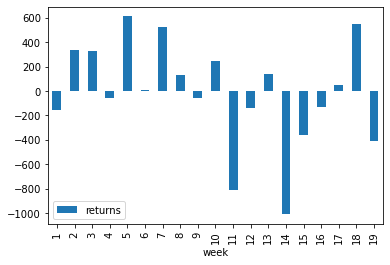

In [8]:
# Using spread advantage of one point

bets_100_01_ps_algo = gambling_df.copy()
bets_100_01_ps_algo['returns'] = bets_100_01_ps_algo.apply(lambda x: get_return_100_spread_algo(x, 1), axis=1)
bets_100_01_ps_algo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [9]:
bets_100_01_ps_algo.sum()['returns']

-220.37000000000012

In [10]:
len(bets_100_01_ps_algo)

264

In [11]:
len(bets_100_01_ps_algo[bets_100_01_ps_algo.returns != 0])

212

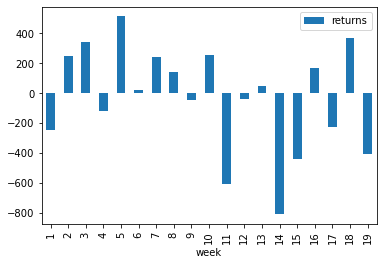

In [12]:
# Using spread advantage of two points

bets_100_02_ps_algo = gambling_df.copy()
bets_100_02_ps_algo['returns'] = bets_100_02_ps_algo.apply(lambda x: get_return_100_spread_algo(x, 2), axis=1)
bets_100_02_ps_algo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [13]:
bets_100_02_ps_algo.sum()['returns']

-620.4999999999998

In [14]:
len(bets_100_02_ps_algo[bets_100_02_ps_algo.returns != 0])

170

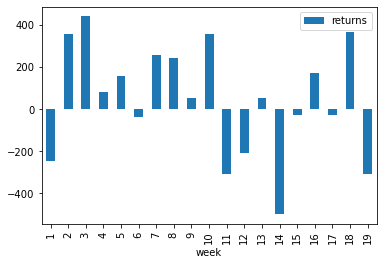

In [15]:
# Using spread advantage of three points

bets_100_03_ps_algo = gambling_df.copy()
bets_100_03_ps_algo['returns'] = bets_100_03_ps_algo.apply(lambda x: get_return_100_spread_algo(x, 3), axis=1)
bets_100_03_ps_algo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [16]:
bets_100_03_ps_algo.sum()['returns']

850.2100000000002

In [17]:
len(bets_100_03_ps_algo[bets_100_03_ps_algo.returns != 0])

129

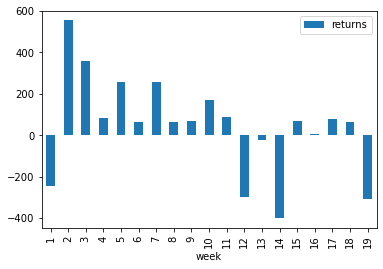

In [18]:
# Using spread advantage of four points

bets_100_04_ps_algo = gambling_df.copy()
bets_100_04_ps_algo['returns'] = bets_100_04_ps_algo.apply(lambda x: get_return_100_spread_algo(x, 4), axis=1)
bets_100_04_ps_algo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [19]:
bets_100_04_ps_algo.sum()['returns']

909.8999999999997

In [20]:
len(bets_100_04_ps_algo[bets_100_04_ps_algo.returns != 0])

92

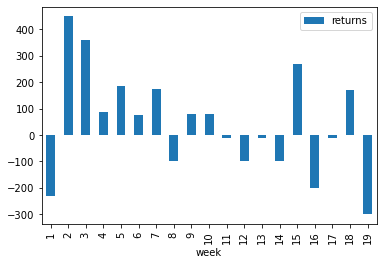

In [21]:
# Using spread advantage of five points

bets_100_05_ps_algo = gambling_df.copy()
bets_100_05_ps_algo['returns'] = bets_100_05_ps_algo.apply(lambda x: get_return_100_spread_algo(x, 5), axis=1)
bets_100_05_ps_algo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [22]:
bets_100_05_ps_algo.sum()['returns']

870.1100000000001

In [23]:
len(bets_100_05_ps_algo[bets_100_05_ps_algo.returns != 0])

56

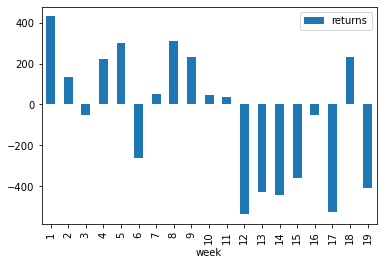

In [24]:
# Look at all of the above, but for elo model

# Using spread advantage of one point

bets_100_01_ps_elo = gambling_df.copy()
bets_100_01_ps_elo['returns'] = bets_100_01_ps_elo.apply(lambda x: get_return_100_spread_elo(x, 1), axis=1)
bets_100_01_ps_elo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [25]:
bets_100_01_ps_elo.sum()['returns']

-1066.6999999999996

In [26]:
len(bets_100_01_ps_elo[bets_100_01_ps_elo.returns != 0])

194

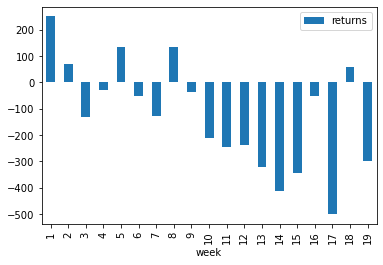

In [27]:
# Look at all of the above, but for elo model

# Using spread advantage of two point

bets_100_02_ps_elo = gambling_df.copy()
bets_100_02_ps_elo['returns'] = bets_100_02_ps_elo.apply(lambda x: get_return_100_spread_elo(x, 2), axis=1)
bets_100_02_ps_elo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [28]:
bets_100_02_ps_elo.sum()['returns']

-2339.8899999999994

In [29]:
len(bets_100_02_ps_elo[bets_100_02_ps_elo.returns != 0])

131

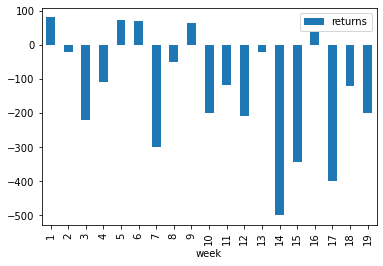

In [30]:
# Look at all of the above, but for elo model

# Using spread advantage of three points

bets_100_03_ps_elo = gambling_df.copy()
bets_100_03_ps_elo['returns'] = bets_100_03_ps_elo.apply(lambda x: get_return_100_spread_elo(x, 3), axis=1)
bets_100_03_ps_elo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [31]:
bets_100_03_ps_elo.sum()['returns']

-2486.94

In [32]:
len(bets_100_03_ps_elo[bets_100_03_ps_elo.returns != 0])

81

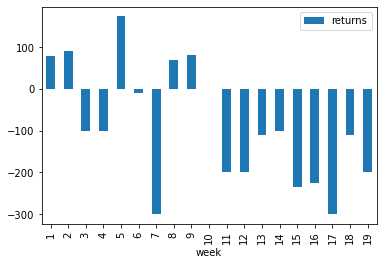

In [33]:
# Look at all of the above, but for elo model

# Using spread advantage of four point

bets_100_04_ps_elo = gambling_df.copy()
bets_100_04_ps_elo['returns'] = bets_100_04_ps_elo.apply(lambda x: get_return_100_spread_elo(x, 4), axis=1)
bets_100_04_ps_elo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [34]:
bets_100_04_ps_elo.sum()['returns']

-1693.9799999999998

In [35]:
len(bets_100_04_ps_elo[bets_100_04_ps_elo.returns != 0])

43

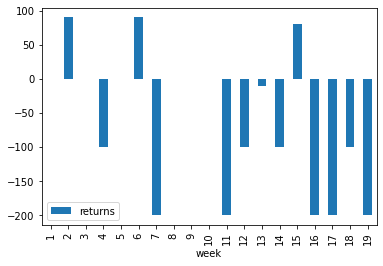

In [36]:
# Look at all of the above, but for elo model

# Using spread advantage of five points

bets_100_05_ps_elo = gambling_df.copy()
bets_100_05_ps_elo['returns'] = bets_100_05_ps_elo.apply(lambda x: get_return_100_spread_elo(x, 5), axis=1)
bets_100_05_ps_elo.groupby(by=['week']).sum()['returns'].reset_index().plot.bar(x='week', y='returns')

In [37]:
bets_100_05_ps_elo.sum()['returns']

-1149.7299999999998

In [38]:
len(bets_100_05_ps_elo[bets_100_05_ps_elo.returns != 0])

19

Average Random Return: -895.6837949999997


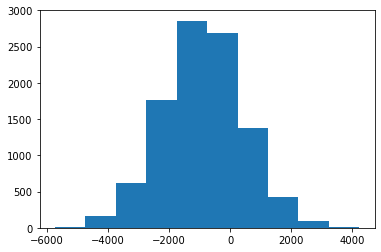

In [39]:
# Check winnings from random betting model for 190 games (approx same as threshold=1)

total_return_list = []
simulations = 10000

for i in range(simulations):
    gambling_sample = gambling_df.sample(n=195)
    gambling_sample['return'] = gambling_sample.apply(lambda x: get_return_100_spread_random(x), axis=1)
    total_return_list.append(gambling_sample.sum()['return'])

print('Average Random Return: {}'.format(np.mean(total_return_list)))

plt.plot()
plt.hist(total_return_list)
plt.show()

In [49]:
# Check where algorithm, elo would have fallen in terms of random guessing percentile

break_even_percentile = scipy.stats.percentileofscore(total_return_list, 0)
approx_algo_winnings = -220
approx_elo_winnings = -1066
algo_percentile = scipy.stats.percentileofscore(total_return_list, approx_algo_winnings)
elo_percentile = scipy.stats.percentileofscore(total_return_list, approx_elo_winnings)

print('Percentile of breaking even: {}'.format(break_even_percentile))

print('Percentile of algorithm winnings: {}'.format(algo_percentile))

print('Percentile of elo winnings: {}'.format(elo_percentile))

Percentile of breaking even: 60.36
Percentile of algorithm winnings: 46.12
Percentile of elo winnings: 4.61


Average Random Return: -674.5863529999999


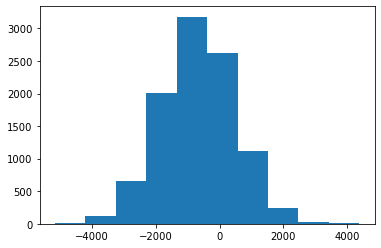

In [41]:
# Check winnings from random betting model for 150 games (approx same as threshold=2)

total_return_list = []
simulations = 10000

for i in range(simulations):
    gambling_sample = gambling_df.sample(n=150)
    gambling_sample['return'] = gambling_sample.apply(lambda x: get_return_100_spread_random(x), axis=1)
    total_return_list.append(gambling_sample.sum()['return'])

print('Average Random Return: {}'.format(np.mean(total_return_list)))

plt.plot()
plt.hist(total_return_list)
plt.show()

In [52]:
# Check where algorithm, elo would have fallen in terms of random guessing percentile

break_even_percentile = scipy.stats.percentileofscore(total_return_list, 0)
approx_algo_winnings = -620
approx_elo_winnings = -2239
algo_percentile = scipy.stats.percentileofscore(total_return_list, approx_algo_winnings)
elo_percentile = scipy.stats.percentileofscore(total_return_list, approx_elo_winnings)

print('Percentile of breaking even: {}'.format(break_even_percentile))

print('Percentile of algorithm winnings: {}'.format(algo_percentile))

print('Percentile of elo winnings: {}'.format(elo_percentile))

Percentile of breaking even: 60.36
Percentile of algorithm winnings: 21.1
Percentile of elo winnings: 0.0


Average Random Return: -487.8183839999998


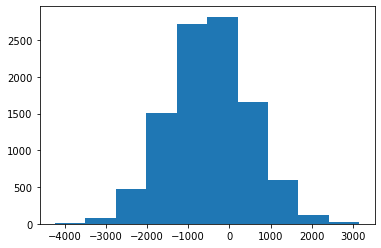

In [53]:
# Check winnings from random betting model for 105 games (approx same as threshold=3)

total_return_list = []
simulations = 10000

for i in range(simulations):
    gambling_sample = gambling_df.sample(n=105)
    gambling_sample['return'] = gambling_sample.apply(lambda x: get_return_100_spread_random(x), axis=1)
    total_return_list.append(gambling_sample.sum()['return'])

print('Average Random Return: {}'.format(np.mean(total_return_list)))

plt.plot()
plt.hist(total_return_list)
plt.show()

In [54]:
# Check where algorithm, elo would have fallen in terms of random guessing percentile

break_even_percentile = scipy.stats.percentileofscore(total_return_list, 0)
approx_algo_winnings = 850
approx_elo_winnings = -2486
algo_percentile = scipy.stats.percentileofscore(total_return_list, approx_algo_winnings)
elo_percentile = scipy.stats.percentileofscore(total_return_list, approx_elo_winnings)

print('Percentile of breaking even: {}'.format(break_even_percentile))

print('Percentile of algorithm winnings: {}'.format(algo_percentile))

print('Percentile of elo winnings: {}'.format(elo_percentile))

Percentile of breaking even: 69.59
Percentile of algorithm winnings: 91.38
Percentile of elo winnings: 1.86


Average Random Return: -322.7488399999999


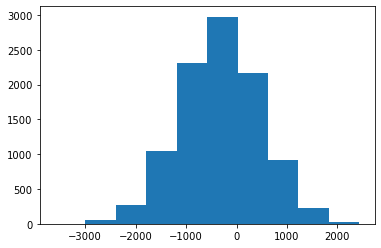

In [56]:
# Check winnings from random betting model for 70 games (approx same as threshold=4)

total_return_list = []
simulations = 10000

for i in range(simulations):
    gambling_sample = gambling_df.sample(n=70)
    gambling_sample['return'] = gambling_sample.apply(lambda x: get_return_100_spread_random(x), axis=1)
    total_return_list.append(gambling_sample.sum()['return'])

print('Average Random Return: {}'.format(np.mean(total_return_list)))

plt.plot()
plt.hist(total_return_list)
plt.show()

In [57]:
# Check where algorithm, elo would have fallen in terms of random guessing percentile

break_even_percentile = scipy.stats.percentileofscore(total_return_list, 0)
approx_algo_winnings = 909
approx_elo_winnings = -1693
algo_percentile = scipy.stats.percentileofscore(total_return_list, approx_algo_winnings)
elo_percentile = scipy.stats.percentileofscore(total_return_list, approx_elo_winnings)

print('Percentile of breaking even: {}'.format(break_even_percentile))

print('Percentile of algorithm winnings: {}'.format(algo_percentile))

print('Percentile of elo winnings: {}'.format(elo_percentile))

Percentile of breaking even: 65.88
Percentile of algorithm winnings: 94.04
Percentile of elo winnings: 4.08


Average Random Return: -154.610039


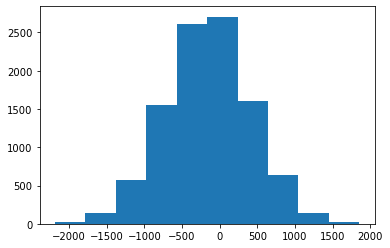

In [58]:
# Check winnings from random betting model for 35 games (approx same as threshold=5)

total_return_list = []
simulations = 10000

for i in range(simulations):
    gambling_sample = gambling_df.sample(n=35)
    gambling_sample['return'] = gambling_sample.apply(lambda x: get_return_100_spread_random(x), axis=1)
    total_return_list.append(gambling_sample.sum()['return'])

print('Average Random Return: {}'.format(np.mean(total_return_list)))

plt.plot()
plt.hist(total_return_list)
plt.show()

In [59]:
# Check where algorithm, elo would have fallen in terms of random guessing percentile

break_even_percentile = scipy.stats.percentileofscore(total_return_list, 0)
approx_algo_winnings = 870
approx_elo_winnings = -1149
algo_percentile = scipy.stats.percentileofscore(total_return_list, approx_algo_winnings)
elo_percentile = scipy.stats.percentileofscore(total_return_list, approx_elo_winnings)

print('Percentile of breaking even: {}'.format(break_even_percentile))

print('Percentile of algorithm winnings: {}'.format(algo_percentile))

print('Percentile of elo winnings: {}'.format(elo_percentile))

Percentile of breaking even: 61.47
Percentile of algorithm winnings: 96.22
Percentile of elo winnings: 3.81
